# Neural network based integrator time-reversibility

In [ ]:
import sys
sys.path.append('..')

import numpy as np
from matplotlib import pyplot as plt
from Code.dynamical_system import *
from Code.time_integrator import *
from Code.neuralnet import *

np.random.seed(2512517)

## Neural network integrator
This class is used to evaluate the time-reversed performance of the dense neural network integrator.

Set system parameters, construct dynamical system and integrator.

The model system we are using here is the harmonic oscillator, defined by the equations of motion

$$
\frac{dx}{dt} = v,\qquad\qquad
\frac{dv}{dt} = -\frac{k}{m}x
$$

The timestep size of the Neural network integrator is set to $\Delta t=\Delta t_{\text{Verlet}}$ where $\Delta t_{\text{Verlet}}$ is the step size of the Verlet integrator that is used for training.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 2)]       0           []                               
                                                                                                  
 flatten (Flatten)              (None, 8)            0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 64)           576         ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           4160        ['dense[0][0]']                  
                                                                                              

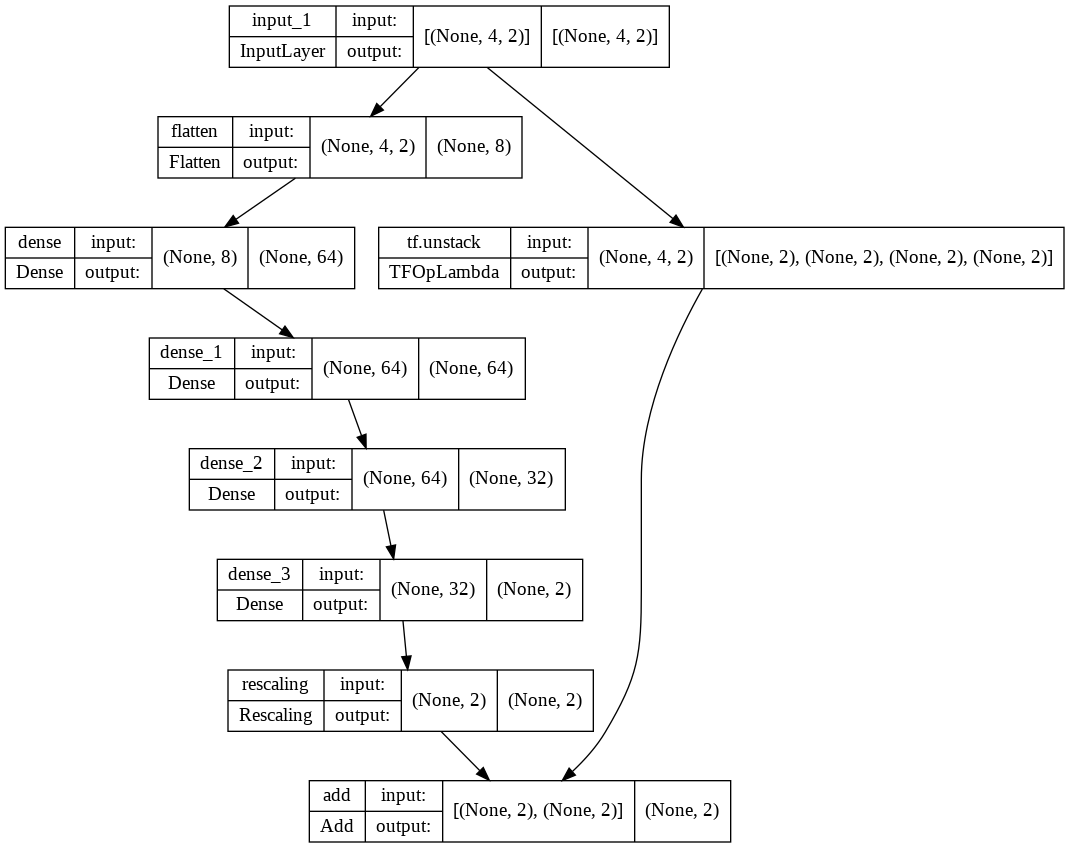

In [ ]:
# mass of particle
mass = 1.2
# spring constant of harmonic oscillator
k_spring = 0.9
# timestep for Verlet integrator
dt_verlet = 0.005
# timestep for neural network integrator
dt_1 = dt_verlet

# number of steps for neural network integrator
nsteps = 4

harmonic_oscillator = HarmonicOscillator(mass,k_spring)

verlet_SHO = VerletIntegrator(harmonic_oscillator,dt_verlet)

nn_integrator_1 = NN5LR3Integrator(harmonic_oscillator,nsteps,dt_1)

#Reversed neural network

nn_integrator_2 = NN5LR3Integrator(harmonic_oscillator,nsteps,-dt_1)


# visualise the neural network model
nn_integrator_1.model.summary()
keras.utils.plot_model(nn_integrator_1.model, show_shapes=True)

In [ ]:
BATCH_SIZE=64

data_generator_1 = DataGenerator(nn_integrator_1,verlet_SHO)
train_batches_1 = data_generator_1.dataset.batch(BATCH_SIZE)


## Train neural network based integrator

In [ ]:
EPOCHS=300
STEPS_PER_EPOCH=100
log_dir = './tb_logs/'
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

result_1 = nn_integrator_1.model.fit(train_batches_1,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                 callbacks=tensorboard_cb)


Epoch 1/300
100/100 [==============================] - 9s 73ms/step - loss: 5.9714e-05
Epoch 2/300
100/100 [==============================] - 3s 33ms/step - loss: 2.3341e-05
Epoch 3/300
100/100 [==============================] - 3s 27ms/step - loss: 6.8924e-06
Epoch 4/300
100/100 [==============================] - 4s 36ms/step - loss: 1.7631e-06
Epoch 5/300
100/100 [==============================] - 4s 36ms/step - loss: 6.3929e-07
Epoch 6/300
100/100 [==============================] - 3s 28ms/step - loss: 3.6589e-07
Epoch 7/300
100/100 [==============================] - 3s 35ms/step - loss: 2.2591e-07
Epoch 8/300
100/100 [==============================] - 3s 26ms/step - loss: 1.6275e-07
Epoch 9/300
100/100 [==============================] - 3s 32ms/step - loss: 1.2369e-07
Epoch 10/300
100/100 [==============================] - 4s 41ms/step - loss: 9.4352e-08
Epoch 11/300
100/100 [==============================] - 3s 30ms/step - loss: 7.5870e-08
Epoch 12/300
100/100 [===================

## Visualise Loss function

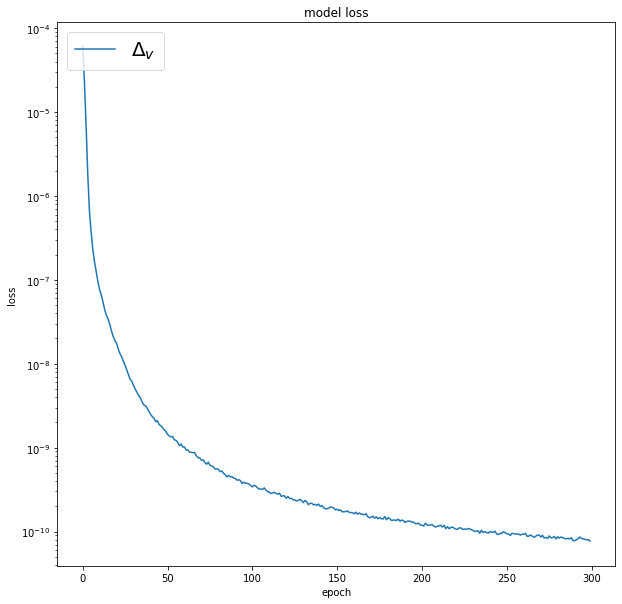

In [ ]:
#print(result.history.keys())

plt.rcParams['figure.figsize'] = [10, 10]

# summarize history for loss
plt.plot(result_1.history['loss'])


plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.legend(['$\Delta_v$'], loc='upper left')
plt.yscale("log")
plt.show()

## Plot trajectories generated to $t=32$ by Verlet integrator and neural 


In [ ]:
# Final time
T_final = 32

# Initial conditions
x = np.zeros(1)
v = np.zeros(1)
x[0] = 2.70
v[0] = -0.6
verlet_SHO.set_state(x,v)

# ==== Verlet integrator ====
t = 0.0
t_verlet_SHO = []
x_verlet_SHO = []
v_verlet_SHO = []
E_verlet_SHO = []



while t<T_final:
    t_verlet_SHO.append(t)
    E_verlet_SHO.append(verlet_SHO.energy())
    x_verlet_SHO.append(verlet_SHO.x[0])
    v_verlet_SHO.append(verlet_SHO.v[0])
    verlet_SHO.integrate(1)
    t += dt_verlet
        

# ==== Neural network integrator ====

#Forward integration direction
nn_integrator_1.dt = dt_1

# Initialise with Verlet integrator
x_initial_1 = np.zeros((nn_integrator_1.nsteps,nn_integrator_1.dynamical_system.dim))
v_initial_1 = np.zeros((nn_integrator_1.nsteps,nn_integrator_1.dynamical_system.dim))
t_nn_1 = []
x_nn_1 = []
v_nn_1 = []
E_nn_1 = []

verlet_SHO.set_state(x,v)
for k in range(nn_integrator_1.nsteps):    
    x_initial_1[k,:] = verlet_SHO.x[:]
    v_initial_1[k,:] = verlet_SHO.v[:]
    verlet_SHO.integrate(int(dt_1/dt_verlet))

nn_integrator_1.set_state(x_initial_1,v_initial_1)
t_1 = (nn_integrator_1.nsteps-1)*nn_integrator_1.dt


#Integrate forwards in time using NN

while t_1<T_final:
    t_nn_1.append(t_1)
    x_nn_1.append(nn_integrator_1.x[0])
    v_nn_1.append(nn_integrator_1.v[0])
    E_nn_1.append(nn_integrator_1.energy())
    nn_integrator_1.integrate(1)
    t_1 += dt_1




##Plot reversed time network integration

In [ ]:
#Replicate weights in forward-time NN into backward time NN

nn_integrator_1.model.save_weights('forward_weights.h5')

nn_integrator_2.model.load_weights('forward_weights.h5')
nn_integrator_2.model
#Initialise reverse-time NN

x_initial_2 = np.zeros((nn_integrator_2.nsteps,nn_integrator_2.dynamical_system.dim))
v_initial_2 = np.zeros((nn_integrator_2.nsteps,nn_integrator_2.dynamical_system.dim))
t_nn_2 = []
x_nn_2 = []
v_nn_2 = []
E_nn_2 = []


#Initialise backward direction with final 4 states of forward direction
for k in range(nn_integrator_2.nsteps):
    x_initial_2[k,:] = x_nn_1[-(k+1)]
    v_initial_2[k,:] = v_nn_1[-(k+1)]

nn_integrator_2.set_state(x_initial_2,v_initial_2)
t_2 = 32-(nn_integrator_2.nsteps-1)*(-nn_integrator_2.dt)

#Integrate backwards in time x

while t_2>(nn_integrator_2.nsteps-1)*(-nn_integrator_2.dt):
    t_nn_2.append(t_2)
    x_nn_2.append(nn_integrator_2.x[0])
    v_nn_2.append(nn_integrator_2.v[0])
    E_nn_2.append(nn_integrator_2.energy())
    nn_integrator_2.integrate(1)
    t_2 -= dt_1




x_nn_1 = np.array(x_nn_1)
x_nn_2 = np.array(x_nn_2)
x_verlet_SHO = np.array(x_verlet_SHO)
v_nn_1 = np.array(v_nn_1)
v_nn_2 = np.array(v_nn_2)
v_verlet_SHO = np.array(v_verlet_SHO)
#t_nn_2.reverse() #reverse t_nn_2 for backwards direction



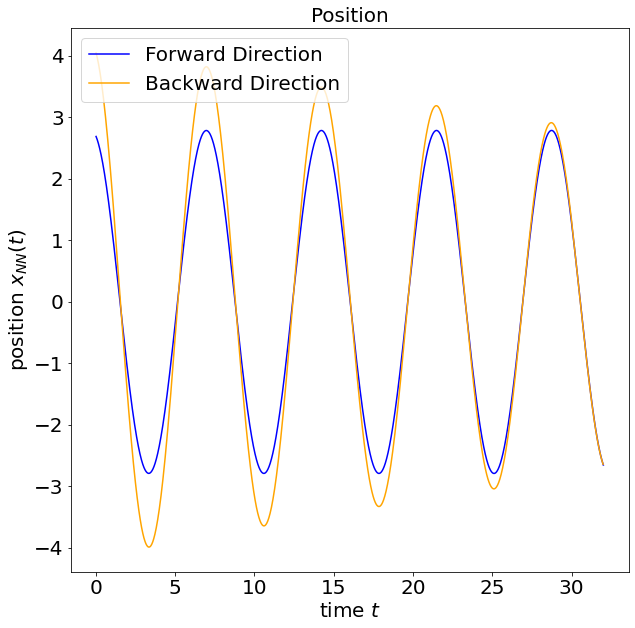

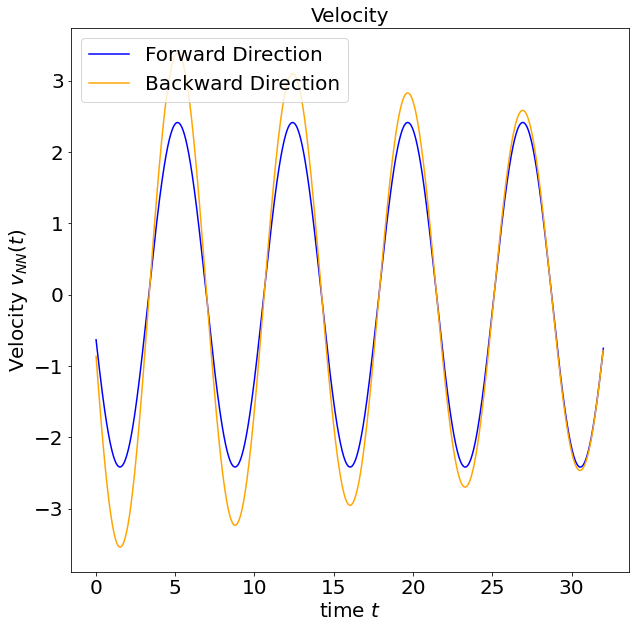

No handles with labels found to put in legend.


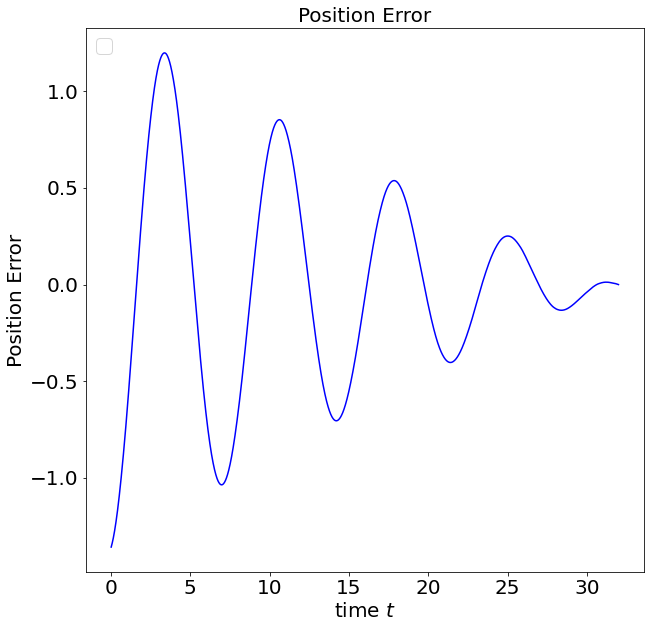

No handles with labels found to put in legend.


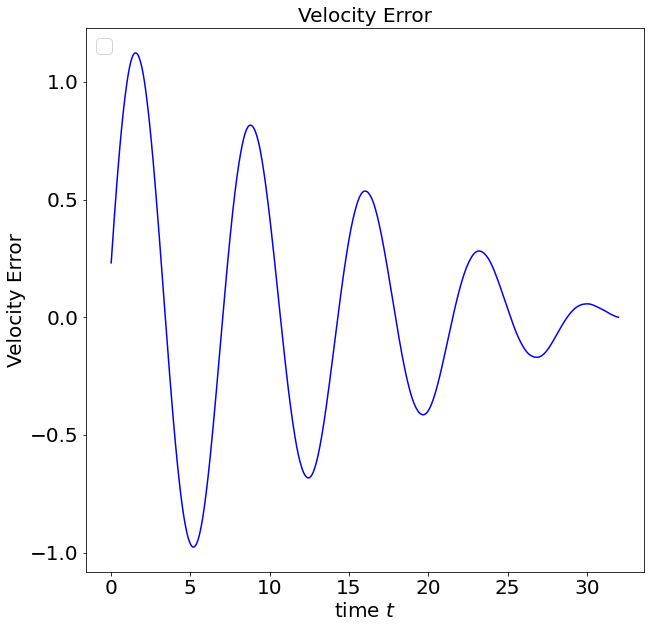

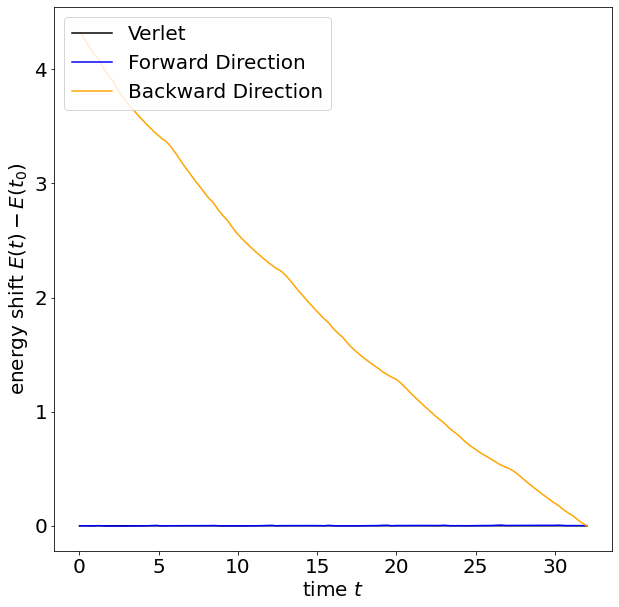

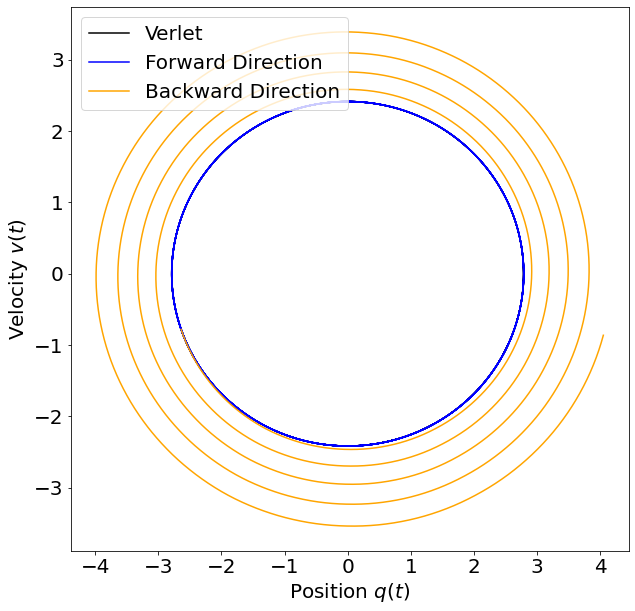

In [ ]:
# Plot position as a function of time
plt.clf()
plt.rcParams['figure.figsize'] = [10, 10]

plt.plot(t_nn_1,x_nn_1,label='Forward Direction',color='blue')
plt.plot(t_nn_2,x_nn_2,label='Backward Direction',color='orange')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('position $x_{NN}(t)$')
ax.set_title('Position')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()

# Plot velocity as a function of time

plt.plot(t_nn_1,v_nn_1,label='Forward Direction',color='blue')
plt.plot(t_nn_2,v_nn_2,label='Backward Direction',color='orange')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('Velocity $v_{NN}(t)$')
ax.set_title('Velocity')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()

# Plot Position error between the two as a function of time

plt.plot(t_nn_1[0:6395],x_nn_1[0:-(nn_integrator_1.nsteps)+1]-np.flip(x_nn_2),color='blue')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('Position Error')
ax.set_title('Position Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()


# Plot velocity error between the two as a function of time

plt.plot(t_nn_1[0:6395],v_nn_1[0:-(nn_integrator_1.nsteps)+1]-np.flip(v_nn_2),color='blue')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('Velocity Error')
ax.set_title('Velocity Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()


plt.clf()
# Plot energy as a function of time
# (subtract energy at time t=0 to show energy drift)

plt.plot(t_verlet_SHO,E_verlet_SHO-E_verlet_SHO[0],label='Verlet',color='black')
plt.plot(t_nn_1,E_nn_1-E_nn_1[0],label='Forward Direction',color='blue')
plt.plot(t_nn_2,E_nn_2-E_nn_1[0],label='Backward Direction',color='orange')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('energy shift $E(t)-E(t_0)$')
#ax.grid()
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

plt.show()

#subplots of position versus velocity for both directions

plt.rcParams['figure.figsize'] = [10, 10]

plt.clf()
plt.plot(x_verlet_SHO,v_verlet_SHO,label='Verlet',color='black')
plt.plot(x_nn_1,v_nn_1,label='Forward Direction',color='blue')
plt.plot(x_nn_2,v_nn_2,label='Backward Direction',color='orange')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_ylabel('Velocity $v(t)$')
ax.set_xlabel('Position $q(t)$')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.show()